# Proyecto
## PlusTI - Detección de fraude
Universidad del Valle de Guatemala<br>
Security Data Science<br>
Pablo Andrés Zamora Vásquez<br>
Carné 21780

## Modelo Base

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [2]:
# Importar el conjunto de datos
df = pd.read_csv('./data/dataset_feature_engineering_v2.csv')

### Dividir el conjunto en entrenamiento y test

In [8]:
X = df.drop(columns=['is_fraud', 'transaction_dt', 'first', 'last', 'dob', 'trans_num'])
y = df['is_fraud']

X_train = df[df['trans_month'] < 12]  # Entrenamiento: meses antes de diciembre 2020
X_test = df[df['trans_month'] == 12]  # Test: diciembre 2020

y_train = X_train['is_fraud']
y_test = X_test['is_fraud']

X_train = X_train.drop(columns=['is_fraud', 'transaction_dt', 'first', 'last', 'dob', 'trans_num'])
X_test = X_test.drop(columns=['is_fraud', 'transaction_dt', 'first', 'last', 'dob', 'trans_num'])

### Codificar variables categóricas

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

# Lista de columnas a codificar
cols_to_encode = ['merchant', 'category', 'job', 'state', 'age_group', 'year_month', 'trans_year_month']

# Inicializar el encoder con manejo de categorías desconocidas
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Aplicar el fit solo al entrenamiento
X_train[cols_to_encode] = oe.fit_transform(X_train[cols_to_encode].astype(str))

# Transformar el test (sin volver a hacer fit)
X_test[cols_to_encode] = oe.transform(X_test[cols_to_encode].astype(str))

# Codificar binarios
X_train['gender'] = X_train['gender'].map({'F': 0, 'M': 1}).fillna(0)
X_test['gender'] = X_test['gender'].map({'F': 0, 'M': 1}).fillna(0)

# Booleanos a 0/1
bool_cols = ['first_time_at_merchant', 'is_weekend']
for col in bool_cols:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)
    
# Eliminar columnas innecesarias
cols_to_drop = ['street', 'city']
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

### Entrenamiento modelo base

In [65]:
train_set = lgb.Dataset(X_train, label=y_train)
test_set = lgb.Dataset(X_test, label=y_test)

base_model = lgb.train(
    params={
        'objective': 'binary',
        'metric': 'auc',
    },
    train_set=train_set,
    valid_sets=[test_set],
)

[LightGBM] [Info] Number of positive: 8801, number of negative: 1562995
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6252
[LightGBM] [Info] Number of data points in the train set: 1571796, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005599 -> initscore=-5.179494
[LightGBM] [Info] Start training from score -5.179494


In [66]:
# Obtener resultados
y_pred = base_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
cr = classification_report(y_test, y_pred_binary, output_dict=True)
print(classification_report(y_test, y_pred_binary))
print(confusion_matrix(y_test, y_pred_binary))
print(f"AUC: {roc_auc_score(y_test, y_pred)}")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
ratio_fp = (tp + fp) / tp if tp != 0 else float('inf')
print(f"Ratio FP: {ratio_fp:.2f}")

base_model_results = {
    'model': 'base_model',
    'precision': cr['1']['precision'],
    'recall': cr['1']['recall'],
    'f1-score': cr['1']['f1-score'],
    'support': cr['1']['support'],
    'auc': roc_auc_score(y_test, y_pred),
    'ratio_fp': ratio_fp,
}

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    279748
           1       0.13      0.73      0.22       850

    accuracy                           0.98    280598
   macro avg       0.56      0.86      0.61    280598
weighted avg       1.00      0.98      0.99    280598

[[275597   4151]
 [   232    618]]
AUC: 0.9435347190622821
Ratio FP: 7.72


### Implementación de métricas personalizadas

Usando la razón entre falsos positivos y verdaderos positivos:

In [49]:
from sklearn.metrics import confusion_matrix

def ratio_fp_metric(y_pred, data):
    y_true = data.get_label()
    y_pred_bin = (y_pred > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()

    if tp == 0:
        ratio = float('inf')  # Evitar división por cero
    else:
        ratio = (tp + fp) / tp

    return 'ratio_fp', ratio, False  # False indica que menor es mejor


In [67]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
}

fP_ratio_model = lgb.train(
    params,
    train_set,
    valid_sets=[test_set],
    feval=ratio_fp_metric,
    callbacks=[lgb.early_stopping(stopping_rounds=10)],
)

[LightGBM] [Info] Number of positive: 8801, number of negative: 1562995
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6252
[LightGBM] [Info] Number of data points in the train set: 1571796, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005599 -> initscore=-5.179494
[LightGBM] [Info] Start training from score -5.179494
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0117299	valid_0's ratio_fp: 1.20436


In [70]:
# Obtener resultados
y_pred = fP_ratio_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
cr = classification_report(y_test, y_pred_binary, output_dict=True)
print(classification_report(y_test, y_pred_binary))
print(confusion_matrix(y_test, y_pred_binary))
print(f"AUC: {roc_auc_score(y_test, y_pred)}")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
ratio_fp = (tp + fp) / tp if tp != 0 else float('inf')
print(f"Ratio FP: {ratio_fp:.2f}")

fp_ratio_model_results = {
    'model': 'fp_ratio_model',
    'precision': cr['1']['precision'],
    'recall': cr['1']['recall'],
    'f1-score': cr['1']['f1-score'],
    'support': cr['1']['support'],
    'auc': roc_auc_score(y_test, y_pred),
    'ratio_fp': ratio_fp,
}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    279748
           1       0.83      0.70      0.76       850

    accuracy                           1.00    280598
   macro avg       0.91      0.85      0.88    280598
weighted avg       1.00      1.00      1.00    280598

[[279626    122]
 [   253    597]]
AUC: 0.8947209126869644
Ratio FP: 1.20


Se logró reducir la cantidad de falsos positivos de 4115 a 122, manteniendo una buena detección (597 fraudes detectados de 850).

Penalizando los falsos positivos:

In [52]:
def penalized_f1(y_pred, data):
    from sklearn.metrics import confusion_matrix

    y_true = data.get_label()
    y_pred_bin = (y_pred > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    # Penalizar el score si hay muchos FP
    penalty = 1 + (fp / (tp + 1e-6))
    penalized = f1 / penalty

    return 'penalized_f1', penalized, True  # True indica que mayor es mejor

In [69]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
}

penalized_f1_model = lgb.train(
    params,
    train_set,
    valid_sets=[test_set],
    feval=penalized_f1,
    callbacks=[lgb.early_stopping(stopping_rounds=10)],
)

[LightGBM] [Info] Number of positive: 8801, number of negative: 1562995
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6252
[LightGBM] [Info] Number of data points in the train set: 1571796, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005599 -> initscore=-5.179494
[LightGBM] [Info] Start training from score -5.179494
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0117299	valid_0's penalized_f1: 0.631868


In [73]:
# Obtener resultados
y_pred = penalized_f1_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
cr = classification_report(y_test, y_pred_binary, output_dict=True)
print(classification_report(y_test, y_pred_binary))
print(confusion_matrix(y_test, y_pred_binary))
print(f"AUC: {roc_auc_score(y_test, y_pred)}")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
ratio_fp = (tp + fp) / tp if tp != 0 else float('inf')
print(f"Ratio FP: {ratio_fp:.2f}")

f1_model_results = {
    'model': 'f1_model',
    'precision': cr['1']['precision'],
    'recall': cr['1']['recall'],
    'f1-score': cr['1']['f1-score'],
    'support': cr['1']['support'],
    'auc': roc_auc_score(y_test, y_pred),
    'ratio_fp': ratio_fp,
}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    279748
           1       0.83      0.70      0.76       850

    accuracy                           1.00    280598
   macro avg       0.91      0.85      0.88    280598
weighted avg       1.00      1.00      1.00    280598

[[279626    122]
 [   253    597]]
AUC: 0.8947209126869644
Ratio FP: 1.20


Asignando mayor peso a los falsos positivos:

In [55]:
def weighted_cost_metric(y_pred, data):
    from sklearn.metrics import confusion_matrix

    y_true = data.get_label()
    y_pred_bin = (y_pred > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()

    cost = 5 * fp + fn  # FP cuesta 5 veces más
    return 'weighted_cost', cost, False  # Menor es mejor

In [72]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
}

weighted_model = lgb.train(
    params,
    train_set,
    valid_sets=[test_set],
    feval=weighted_cost_metric,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

[LightGBM] [Info] Number of positive: 8801, number of negative: 1562995
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6252
[LightGBM] [Info] Number of data points in the train set: 1571796, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005599 -> initscore=-5.179494
[LightGBM] [Info] Start training from score -5.179494
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0117299	valid_0's weighted_cost: 863


In [74]:
# Obtener resultados
y_pred = weighted_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
cr = classification_report(y_test, y_pred_binary, output_dict=True)
print(classification_report(y_test, y_pred_binary))
print(confusion_matrix(y_test, y_pred_binary))
print(f"AUC: {roc_auc_score(y_test, y_pred)}")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
ratio_fp = (tp + fp) / tp if tp != 0 else float('inf')
print(f"Ratio FP: {ratio_fp:.2f}")

weighted_model_results = {
    'model': 'weighted_model',
    'precision': cr['1']['precision'],
    'recall': cr['1']['recall'],
    'f1-score': cr['1']['f1-score'],
    'support': cr['1']['support'],
    'auc': roc_auc_score(y_test, y_pred),
    'ratio_fp': ratio_fp,
}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    279748
           1       0.83      0.70      0.76       850

    accuracy                           1.00    280598
   macro avg       0.91      0.85      0.88    280598
weighted avg       1.00      1.00      1.00    280598

[[279626    122]
 [   253    597]]
AUC: 0.8947209126869644
Ratio FP: 1.20


### Resultados

In [77]:
import matplotlib.pyplot as plt

models_results = [base_model_results, fp_ratio_model_results, f1_model_results, weighted_model_results]
results_df = pd.DataFrame(models_results)
results_df

,model,precision,recall,f1-score,support,auc,ratio_fp
0,base_model,0.129587,0.727059,0.219968,850.0,0.943535,7.716828
1,fp_ratio_model,0.830320,0.702353,0.760994,850.0,0.894721,1.204355
2,f1_model,0.830320,0.702353,0.760994,850.0,0.894721,1.204355
3,weighted_model,0.830320,0.702353,0.760994,850.0,0.894721,1.204355


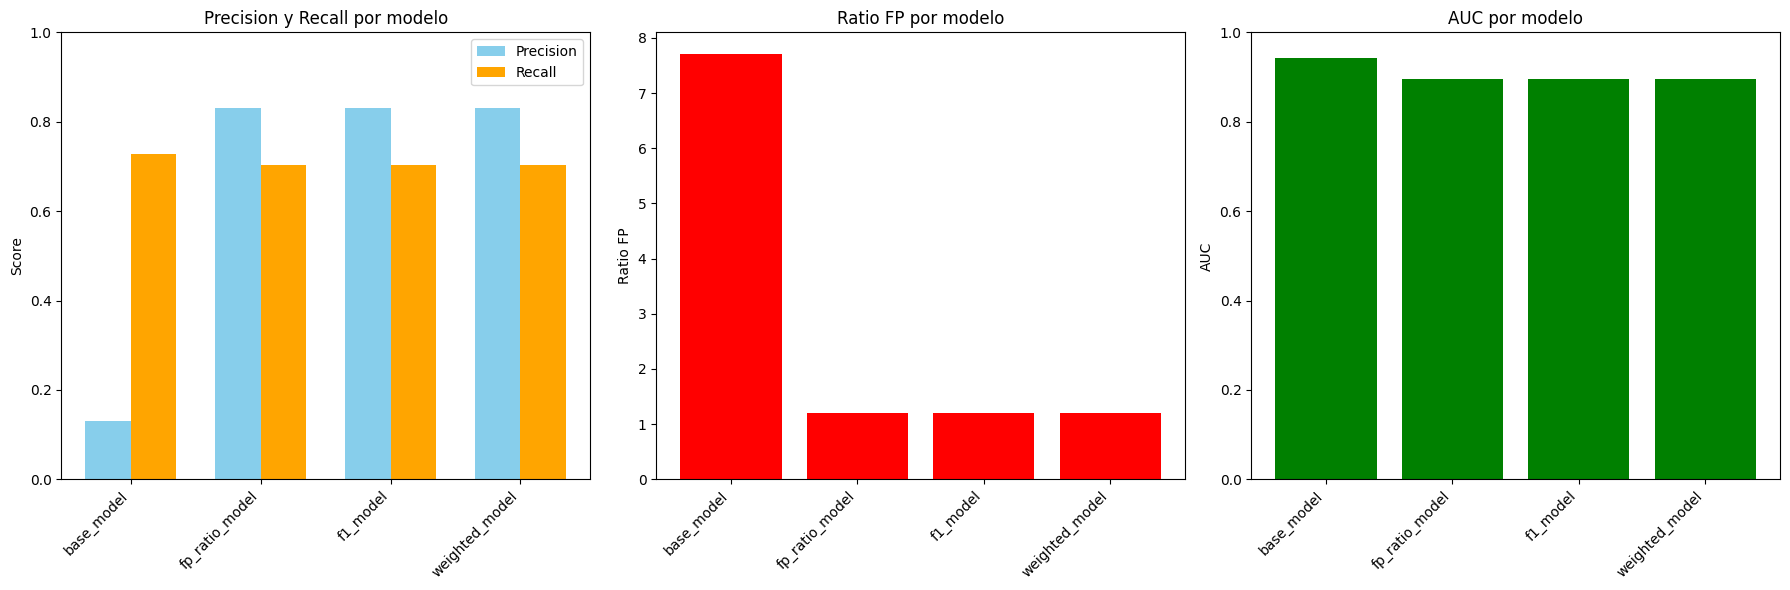

In [81]:
models = results_df['model'].tolist()
x = np.arange(len(results_df))
width = 0.35

plt.figure(figsize=(18, 6))

# Gráfico de Precision y Recall
plt.subplot(1, 3, 1)
plt.bar(x - width/2, results_df['precision'], width, label='Precision', color='skyblue')
plt.bar(x + width/2, results_df['recall'], width, label='Recall', color='orange')
plt.xticks(x, models, rotation=45, ha='right')
plt.title("Precision y Recall por modelo")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()

# Gráfico de Ratio FP
plt.subplot(1, 3, 2)
plt.bar(models, results_df['ratio_fp'], color='red')
plt.xticks(rotation=45, ha='right')
plt.title("Ratio FP por modelo")
plt.ylabel("Ratio FP")

# Gráfico de AUC
plt.subplot(1, 3, 3)
plt.bar(models, results_df['auc'], color='green')
plt.xticks(rotation=45, ha='right')
plt.title("AUC por modelo")
plt.ylabel("AUC")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()